# Localized Semantic Editing of StyleGAN outputs

Introduced in the paper:<br>
> Edo Collins, Raja Bala, Bob Price and Sabine Süsstrunk. _Editing in Style: Uncovering the Local Semantics of GANs_.  IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2020.

This demo illustrates a simple and effective method for making local, semantically-aware edits to a _target_ GAN output image. This is accomplished by borrowing styles from a _source_ image, also a GAN output.

The method requires neither supervision from an external model, nor involves complex spatial morphing operations. Instead, it relies on the emergent disentanglement of semantic objects that is learned by StyleGAN during its training, which we detect using Spherical _k_-means.

The implementation below relies on PyTorch and requires downloading additional parameter files found here: https://drive.google.com/open?id=1GYzEzOCaI8FUS6JHdt6g9UfNTmpO08Tt

In [1]:
!git clone https://github.com/IVRL/GANLocalEditing

Cloning into 'GANLocalEditing'...
remote: Enumerating objects: 27, done.
remote: Total 27 (delta 0), reused 0 (delta 0), pack-reused 27
Unpacking objects: 100% (27/27), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/GANLocalEditing
%cp -r /content/drive/MyDrive/Lernen/Coxi/IANNwTF/GANLocalEditing/catalogs .
%cp -r /content/drive/MyDrive/Lernen/Coxi/IANNwTF/GANLocalEditing/state_dicts/ .

/content/GANLocalEditing


In [4]:
import torch
import stylegan                                     # StyleGAN model
from stylegan_output import GANOutputs              # Data structure to hold GAN outputs
import ptutils                                      # Helper tensor functions
import visutils                                     # Visualization functions
from factor_catalog import FactorCatalog            # Spherical k-means and the M matrix (Eq. 1)
from style_interpolator import StyleInterpolator    # The 'sequential' style-interpolator (Eq. 5)
import cielab                                       # Helper functions for CIELAB color-space

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Choose a dataset

In [5]:
dataset_name = 'FFHQ'
#dataset_name = 'bedrooms'

Load the appropriate StyleGAN model

In [6]:
root_dir = './state_dicts/' # See comment above regarding additional files
if dataset_name == 'bedrooms':
    base_filename = 'bedrooms-256x256'
    truncation = 0.5
elif dataset_name == 'FFHQ':
    base_filename = 'ffhq-1024x1024'
    truncation = 0.7

G = stylegan.StyleGAN.load_from_pth('{}Gs_karras2019stylegan-{}.pt'.format(root_dir, base_filename)).eval()
G = G.cuda()
G.g_synthesis.set_noise(mode='fixed')

Load the pre-computed spherical k-means clusters, and provide them to the style interpolator

In [7]:
catalog = torch.load('./catalogs/stylegan1_{}.pkl'.format(dataset_name)) # See comment above regarding additional files
si_wf = StyleInterpolator(catalog, bias=False)

Generate some examples

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


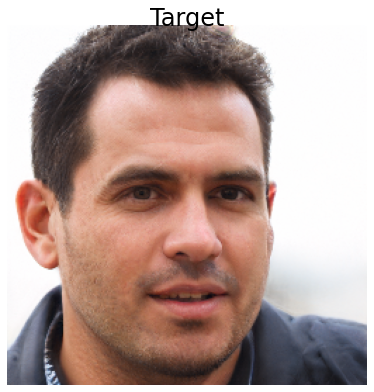

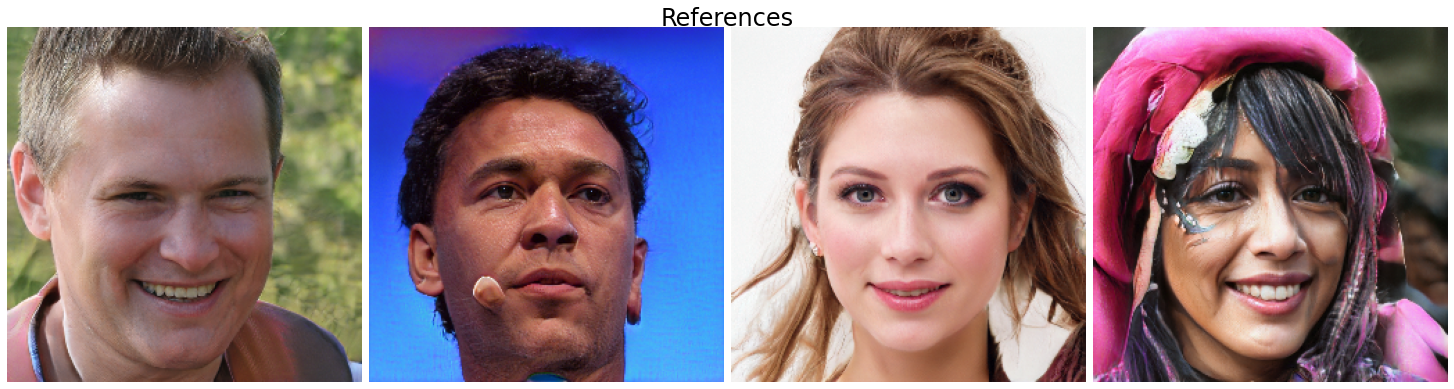

In [8]:
if dataset_name == 'FFHQ':
    gs = GANOutputs.from_seed(5, 2001)
elif dataset_name == 'bedrooms':
    gs = GANOutputs.from_seed((0,33,3,19,34), 6813)

with torch.no_grad():
    
    gs.ys = G.z_to_ys(gs.z.cuda(), truncation=truncation)
    rgb = G.ys_to_rgb(gs.ys)
    rgb = (rgb.clamp(-1, 1) + 1) / 2
    rgb = rgb.cpu()
    gs.rgb = ptutils.MultiResolutionStore(rgb)
        
    gs1 = gs[:1]
    gs2 = gs[1:]

res=256
i, n = 0,4
visutils.show(gs1.rgb.get(res)[i:i+n].permute(0,2,3,1).cpu(), title='Target')
visutils.show(gs2.rgb.get(res)[i:i+n].permute(0,2,3,1).cpu(), title='References')

Transfer object styles from refernces to target 

In [9]:
part_gs = {}

def get_epsilons(epsilon, low_res_epsilon=0):
    epsilons = [epsilon]*len(G.AdaIN_layers)
    for i in range(4): epsilons[i] = low_res_epsilon
    return epsilons

if dataset_name == 'FFHQ':
    parts_thresholds = {
        'eyes': (0.1, get_epsilons(50, 5)),
        'nose': (0.1, get_epsilons(30, 5)),
        'mouth': (0.1, get_epsilons(50, 5)),
    }

elif dataset_name == 'bedrooms':
    parts_thresholds = {
        'bed': (0.01, get_epsilons(120)),
        'pillow': (0.05, get_epsilons(100)),
        'window': (0.05, get_epsilons(100)),
    }

for label, (rho, epsilon) in parts_thresholds.items():
        key = (label)
        part_gs[key]  = GANOutputs()
        part_gs[key].ys = si_wf.interpolate_ys(gs1.ys, gs2.ys, label, rho, epsilon)
        with torch.no_grad():
                rgb = G.ys_to_rgb(part_gs[key].ys)
                rgb = (rgb.clamp(-1, 1) + 1) / 2
                rgb = rgb.cpu()
                part_gs[key].rgb = ptutils.MultiResolutionStore(rgb)

View the results

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


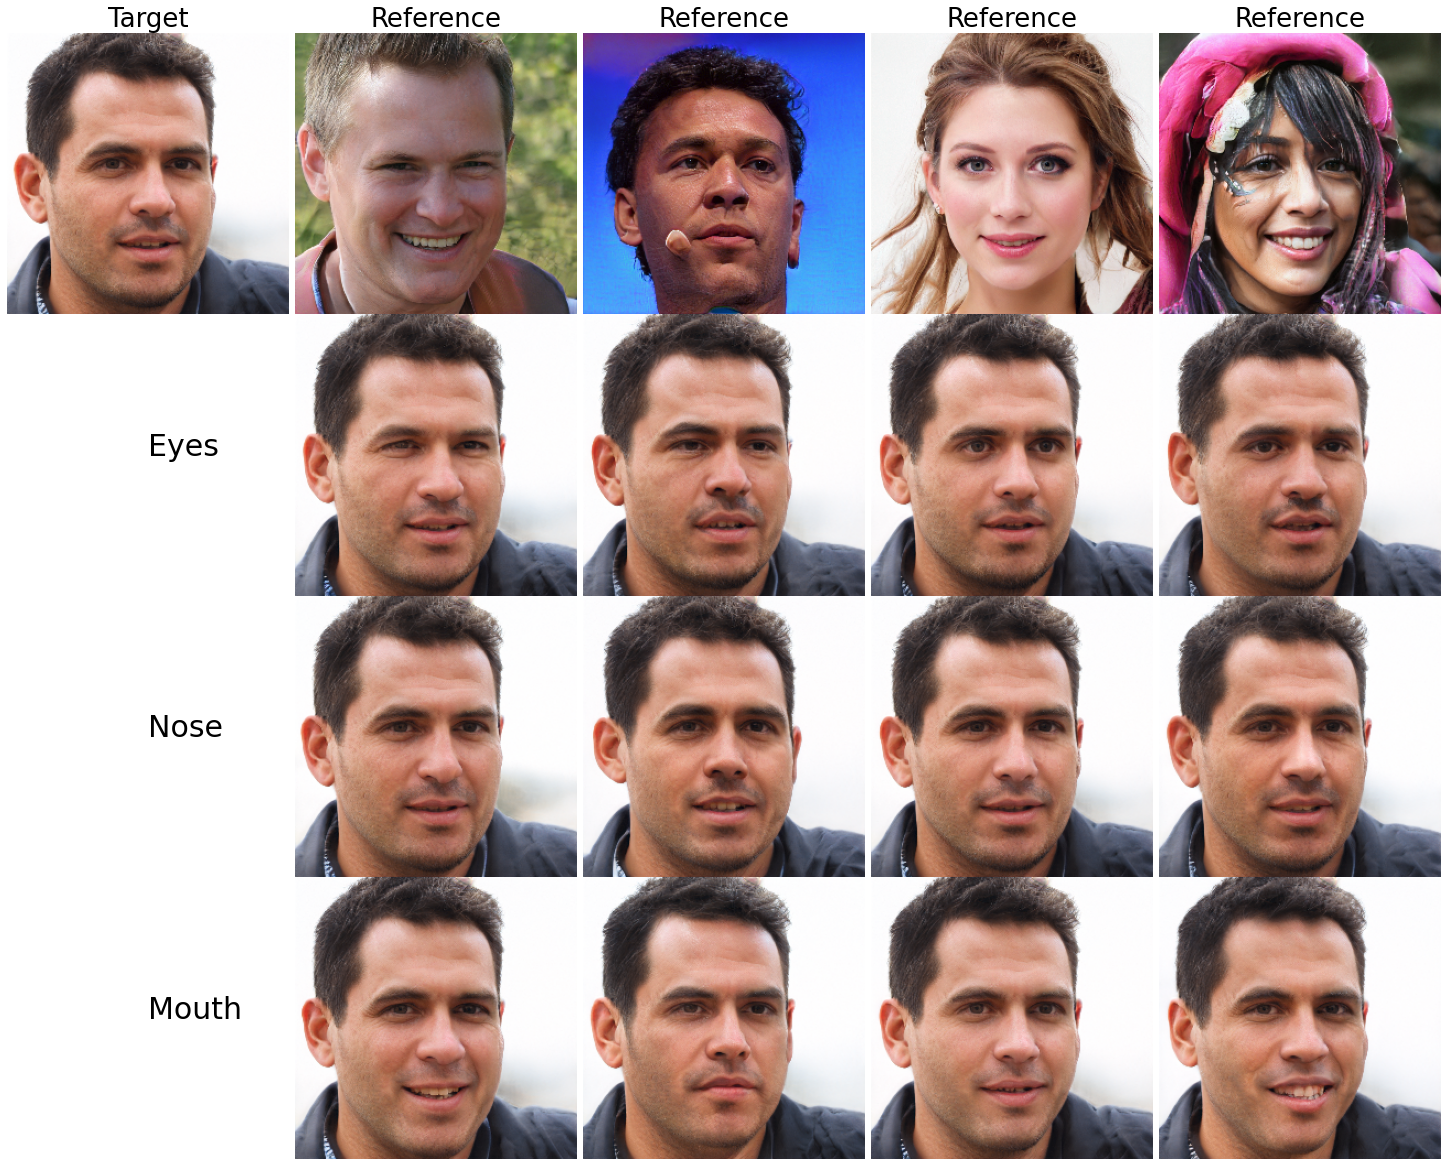

In [10]:
res = 256
visutils.part_grid(gs1.rgb.get(res), gs2.rgb.get(res), {k: v.rgb.get(res) for k,v in part_gs.items()});

View the MSE in CIELAB color-space, between the edited output and the target image

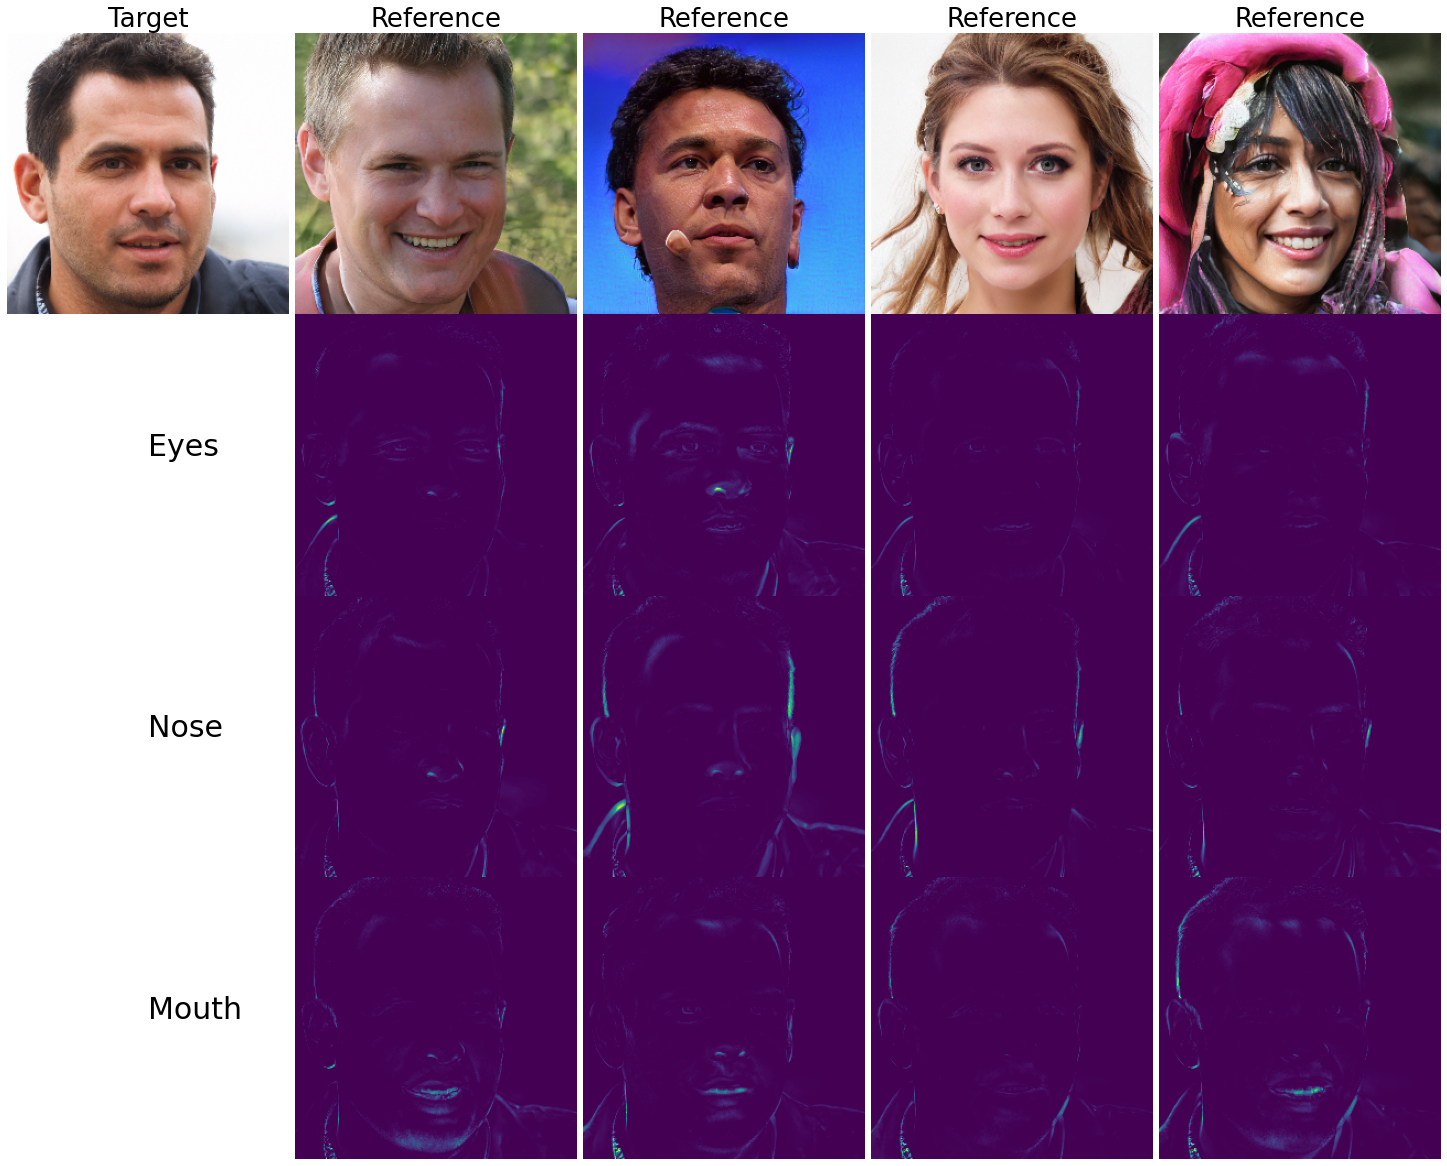

In [11]:
res = 256
normalize = lambda x: x/x.max()
visutils.part_grid(gs1.rgb.get(res), gs2.rgb.get(res),
                 {k: normalize(cielab.squared_error(v.rgb.get(res), gs1.rgb.get(res))) for k,v in part_gs.items()});

# My code

In [12]:
# gs
#GANOutputs()
print(gs)
print(gs.__class__)
print(dir(gs))
# gets added in this notebook only
print(gs.rgb)
print(gs[:1])

5 GANOutput(s): (seed: 2001, indices: (0, 1, 2, 3, 4))
<class 'stylegan_output.GANOutputs'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'from_seed', 'rgb', 'seed', 'seed_indices', 'ys', 'z']
MultiResolutionStore torch.Size([5, 3, 1024, 1024]): [1024]
1 GANOutput(s)


## z_to_ys

### z_to_w

In [13]:
# inspect g_mapping. Just consists of PixelNormLayer and MyLinear's with LeakyReLU. 
#See https://github.com/HSinger04/VOGUE-Reimplementation/blob/d9f6442163ae3e3d503e752f04fabf56cc35f5bc/EditingInStyle/stylegan.py
print(G.g_mapping)

G_mapping(
  (pixel_norm): PixelNormLayer()
  (dense0): MyLinear()
  (dense0_act): LeakyReLU(negative_slope=0.2)
  (dense1): MyLinear()
  (dense1_act): LeakyReLU(negative_slope=0.2)
  (dense2): MyLinear()
  (dense2_act): LeakyReLU(negative_slope=0.2)
  (dense3): MyLinear()
  (dense3_act): LeakyReLU(negative_slope=0.2)
  (dense4): MyLinear()
  (dense4_act): LeakyReLU(negative_slope=0.2)
  (dense5): MyLinear()
  (dense5_act): LeakyReLU(negative_slope=0.2)
  (dense6): MyLinear()
  (dense6_act): LeakyReLU(negative_slope=0.2)
  (dense7): MyLinear()
  (dense7_act): LeakyReLU(negative_slope=0.2)
)


In [14]:
# inspect truncation
# See https://github.com/HSinger04/VOGUE-Reimplementation/blob/main/EditingInStyle/stylegan.py
# Just a linear interpolation thingy
print(G.truncation)

Truncation()


### w_to_ys

In [15]:
# inspect g_style. See https://github.com/HSinger04/VOGUE-Reimplementation/blob/main/EditingInStyle/stylegan.py
# Just a linear transformer
print(G.g_style)

G_style(
  (style_layers): ModuleDict(
    (4x4_0): StyleMod(
      (lin): MyLinear()
    )
    (4x4_1): StyleMod(
      (lin): MyLinear()
    )
    (8x8_0): StyleMod(
      (lin): MyLinear()
    )
    (8x8_1): StyleMod(
      (lin): MyLinear()
    )
    (16x16_0): StyleMod(
      (lin): MyLinear()
    )
    (16x16_1): StyleMod(
      (lin): MyLinear()
    )
    (32x32_0): StyleMod(
      (lin): MyLinear()
    )
    (32x32_1): StyleMod(
      (lin): MyLinear()
    )
    (64x64_0): StyleMod(
      (lin): MyLinear()
    )
    (64x64_1): StyleMod(
      (lin): MyLinear()
    )
    (128x128_0): StyleMod(
      (lin): MyLinear()
    )
    (128x128_1): StyleMod(
      (lin): MyLinear()
    )
    (256x256_0): StyleMod(
      (lin): MyLinear()
    )
    (256x256_1): StyleMod(
      (lin): MyLinear()
    )
    (512x512_0): StyleMod(
      (lin): MyLinear()
    )
    (512x512_1): StyleMod(
      (lin): MyLinear()
    )
    (1024x1024_0): StyleMod(
      (lin): MyLinear()
    )
    (1024x1024_1):

## Activation tensor

In [23]:
# Spherical k-means
print(catalog.__class__)
# catalog.M[0].shape == [8, 512]
print(catalog.M[0].shape)

<class 'factor_catalog.FactorCatalog'>
torch.Size([8, 512])
